# Fake News Project

1. Initial EDA
2. Analysis with Binary labels (fake vs. reliable)

    a. Disregarding domain (web source)
        i. Sentiment analysis
        ii. Prediction
        
    b. Sampling with domain in consideration
        i. Prediction
        
    c. Topic Modeling
        
        
3. Analysis with Multi-class labels

    a. Four largest labels - classification
    
    b. All labels - classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import collections




from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.corpus import sentiwordnet as swn

from textblob import TextBlob

import gensim
from gensim import corpora
from gensim import models

import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text 

from xgboost import XGBClassifier


## Initial EDA

In [36]:
df = pd.read_csv('newly_sampled_data.csv')

In [37]:
df.shape

(10000, 16)

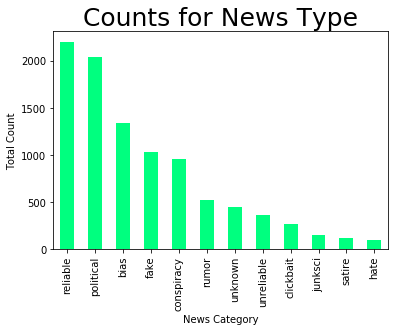

In [38]:
df.type.value_counts().plot(kind='bar', color='springgreen')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.title("Counts for News Type", fontsize=25)
plt.savefig('newstypecounts.png', bbox_inches='tight', dpi = 300)

Text(0.5, 1.0, 'Counts for Domain')

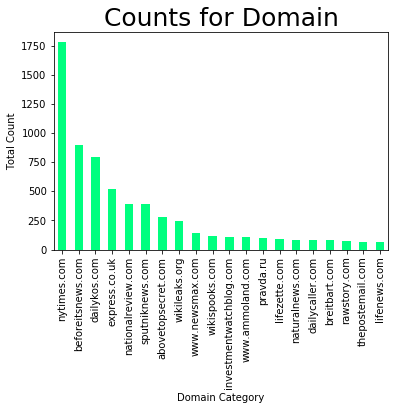

In [39]:
df.domain.value_counts().nlargest(20).plot(kind='bar', color='springgreen')
plt.xlabel('Domain Category')
plt.ylabel('Total Count')
plt.title("Counts for Domain", fontsize=25)

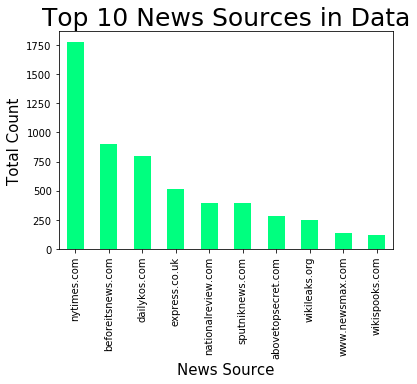

In [40]:
valcounts_domain = df.domain.value_counts()
topten_domain = valcounts_domain.head(10)
topten_domain.plot(kind='bar', color='springgreen')
plt.xlabel('News Source', fontsize=15)
plt.ylabel('Total Count', fontsize=15)
plt.title("Top 10 News Sources in Data", fontsize=25)
plt.savefig('top10newssources.png', bbox_inches='tight', dpi = 300)

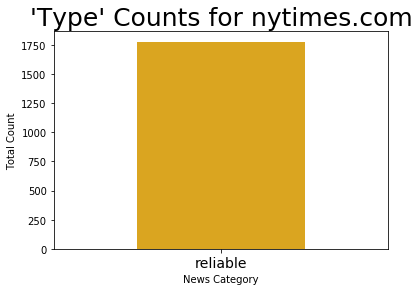

In [41]:
nytimes = df.loc[df['domain'] =='nytimes.com'] 
nytimes.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for nytimes.com", fontsize=25)
plt.savefig('nytimes.png', bbox_inches='tight', dpi = 300)

The dataset defines every document from The New York Times as being 'reliable'.

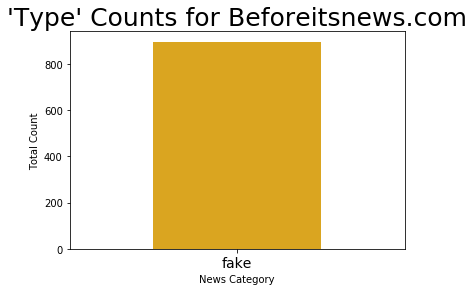

In [42]:
beforeitsnews = df.loc[df['domain'] =='beforeitsnews.com'] 
beforeitsnews.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for Beforeitsnews.com", fontsize=25)
plt.savefig('beforeitsnews.png', bbox_inches='tight',  dpi = 300)

Similarly, every single article from beforeitsnews.com is considered to be 'fake' in the dataset. 

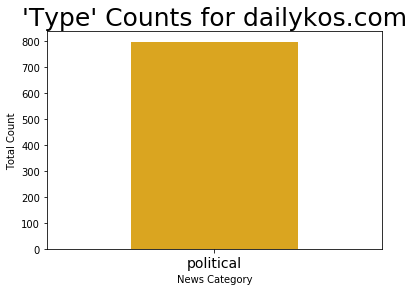

In [43]:
dailykos = df.loc[df['domain'] =='dailykos.com'] 
dailykos.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for dailykos.com", fontsize=25)
plt.savefig('dailykos.png', bbox_inches='tight', dpi = 300)

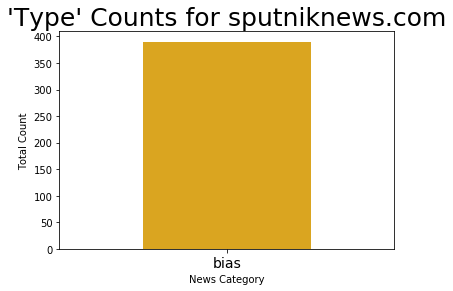

In [44]:
sputnik = df.loc[df['domain'] =='sputniknews.com'] 
sputnik.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for sputniknews.com", fontsize=25)
plt.savefig('sputnik.png', bbox_inches='tight', dpi = 300)

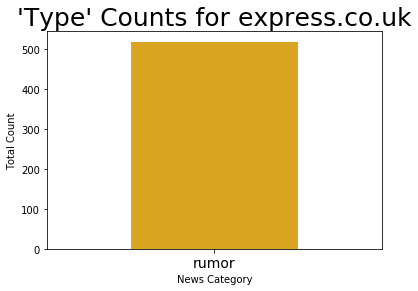

In [45]:
express = df.loc[df['domain'] =='express.co.uk'] 
express.type.value_counts().plot(kind='bar', color='goldenrod')
plt.xlabel('News Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts for express.co.uk", fontsize=25)
plt.savefig('express.co.uk.png', bbox_inches='tight', dpi = 300)

It should be noted that there is inherent bias in this dataset from the labelling of every single article from a given source as being 'rumor', 'junksci', 'bias', or 'political', as opposed to 'reliable', as any given source will contain a wide variety of documents, with varying levels of veracity.

## Binary Labels

## 'Fake' vs. 'Reliable' news in dataset

In [46]:
df = pd.read_csv('complete_new_data.csv')

In [47]:
df.shape

(20000, 16)

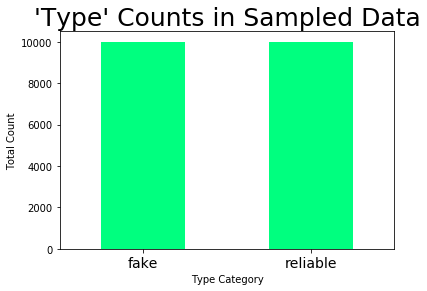

In [48]:
df.type.value_counts().plot(kind='bar', color='springgreen')
plt.xlabel('Type Category')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=0)
plt.title("'Type' Counts in Sampled Data", fontsize=25)
plt.savefig('typecounts.png', bbox_inches='tight', dpi = 300)

10,000 articles labeled 'fake' and '10,000' articles labelled 'reliable' have been sampled from the larger dataset. 

In [49]:
df = df.drop(['tags', 'summary', 'source'], axis=1)

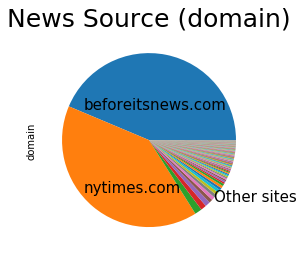

In [50]:
df.domain.value_counts().plot(kind='pie',labels= None)
plt.text(-0.75, 0.35, 'beforeitsnews.com', dict(size=15))
plt.text(-0.75, -0.6, 'nytimes.com', dict(size=15))
plt.text(0.75, -0.7, 'Other sites', dict(size=15))
plt.title("News Source (domain)", fontsize=25)
plt.savefig('newssourcepie.png', bbox_inches='tight', dpi = 300)

## Sentiment Analysis with VADER and textblob

In [51]:
fake = df[df['type']=='fake']

In [52]:
fake.shape

(10000, 13)

In [53]:
fakecontent = []
for index, row in fake.iterrows():
    fakecontent.append(row['content'])

In [54]:
print (len(fakecontent))

10000


In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for doc in fakecontent:
    pol_score = sia.polarity_scores(doc)
    pol_score['content'] = doc
    results.append(pol_score)

In [56]:
fakedf = pd.DataFrame.from_records(results)

In [57]:
fakedf.head()

,compound,content,neg,neu,pos
0,0.9689,"(Before It's News)\n\nOkay, so I have had one ...",0.080,0.653,0.266
1,0.9946,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",0.014,0.914,0.072
2,0.9966,Headline: Bitcoin & Blockchain Searches Exceed...,0.004,0.898,0.098
3,-0.9949,Go for it\n\n(Before It's News)\n\nThe morning...,0.133,0.786,0.081
4,-0.9460,Irish bank flight quickens despite EU rescue\n...,0.085,0.856,0.059


In [58]:
fakedf['label'] = 0
fakedf.loc[fakedf['compound'] > 0.2, 'label'] = 1
fakedf.loc[fakedf['compound'] < -0.2, 'label'] = -1

In [59]:
fakedf.label.value_counts()

 1    5939
-1    3464
 0     597
Name: label, dtype: int64

In [60]:
print (fakedf['compound'].mean())

0.22222996999999992


In [61]:
print (fakedf['neg'].mean())

0.07293319999999968


In [62]:
print (fakedf['neu'].mean())

0.8347048000000006


In [63]:
print (fakedf['pos'].mean())

0.09234690000000038


In [64]:
def textblob_polarity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[0]

In [65]:
fakedf["textblob_polarity_score"] = fakedf["content"].apply(textblob_polarity_score)

In [66]:
def textblob_subjectivity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[1]

In [67]:
fakedf["textblob_subjectivity_score"] = fakedf["content"].apply(textblob_subjectivity_score)

In [68]:
fakedf['text_blob_polarity_label'] = 0
fakedf.loc[fakedf['textblob_polarity_score'] > 0.2, 'text_blob_polarity_label'] = 1
fakedf.loc[fakedf['textblob_polarity_score'] < -0.2, 'text_blob_polarity_label'] = -1

In [69]:
fakedf['text_blob_subjectivity_label'] = 0
fakedf.loc[fakedf['textblob_subjectivity_score'] > 0.55, 'text_blob_subjectivity_label'] = 1
fakedf.loc[fakedf['textblob_subjectivity_score'] < 0.45, 'text_blob_subjectivity_label'] = -1

In [70]:
fakedf[fakedf['textblob_subjectivity_score']>=.5].count()

compound                        2356
content                         2356
neg                             2356
neu                             2356
pos                             2356
label                           2356
textblob_polarity_score         2356
textblob_subjectivity_score     2356
text_blob_polarity_label        2356
text_blob_subjectivity_label    2356
dtype: int64

In [71]:
fakedf.text_blob_polarity_label.value_counts()

 0    8118
 1    1749
-1     133
Name: text_blob_polarity_label, dtype: int64

In [72]:
fakedf.text_blob_subjectivity_label.value_counts()

-1    5784
 0    3088
 1    1128
Name: text_blob_subjectivity_label, dtype: int64

In [73]:
print (fakedf['textblob_polarity_score'].mean())

0.1050328751697413


In [74]:
print (fakedf['textblob_subjectivity_score'].mean())

0.41753126695216386


In [75]:
reliable = df[df['type']=='reliable']

In [76]:
relcontent = []

In [77]:
for index, row in reliable.iterrows():
    relcontent.append(row['content'])

In [78]:
relresults = []
for doc in relcontent:
    pol_score = sia.polarity_scores(doc)
    pol_score['content'] = doc
    relresults.append(pol_score)

In [79]:
reldf = pd.DataFrame.from_records(relresults)



In [80]:
reldf['label'] = 0
reldf.loc[reldf['compound'] > 0.2, 'label'] = 1
reldf.loc[reldf['compound'] < -0.2, 'label'] = -1

In [81]:
reldf.label.value_counts()

 1    6721
-1    2581
 0     698
Name: label, dtype: int64

In [82]:
print (reldf['compound'].mean())

0.3772843899999984


In [83]:
print (reldf['neg'].mean())

0.05900119999999966


In [84]:
print (reldf['neu'].mean())

0.8484762999999974


In [85]:
print (reldf['pos'].mean())

0.09252050000000059


In [86]:
def textblob_polarity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[0]

In [87]:
reldf["textblob_polarity_score"] = reldf["content"].apply(textblob_polarity_score)

In [88]:
def textblob_subjectivity_score(text):
    blob = TextBlob(text)
    return blob.sentiment[1]

In [89]:
reldf["textblob_subjectivity_score"] = reldf["content"].apply(textblob_subjectivity_score)

In [90]:
reldf['text_blob_polarity_label'] = 0
reldf.loc[reldf['textblob_polarity_score'] > 0.2, 'text_blob_polarity_label'] = 1
reldf.loc[reldf['textblob_polarity_score'] < -0.2, 'text_blob_polarity_label'] = -1

In [91]:
reldf['text_blob_subjectivity_label'] = 0
reldf.loc[reldf['textblob_subjectivity_score'] > 0.55, 'text_blob_subjectivity_label'] = 1
reldf.loc[reldf['textblob_subjectivity_score'] < 0.45, 'text_blob_subjectivity_label'] = -1

In [92]:
reldf[reldf['textblob_subjectivity_score']>=.5].count()

compound                        1715
content                         1715
neg                             1715
neu                             1715
pos                             1715
label                           1715
textblob_polarity_score         1715
textblob_subjectivity_score     1715
text_blob_polarity_label        1715
text_blob_subjectivity_label    1715
dtype: int64

In [93]:
reldf.text_blob_polarity_label.value_counts()

 0    8752
 1    1175
-1      73
Name: text_blob_polarity_label, dtype: int64

In [94]:
reldf.text_blob_subjectivity_label.value_counts()

-1    6800
 0    2438
 1     762
Name: text_blob_subjectivity_label, dtype: int64

In [95]:
print (reldf['textblob_polarity_score'].mean())

0.09809097950087405


In [96]:
print (reldf['textblob_subjectivity_score'].mean())

0.40756980415620375


## Classification (Predictive Analysis)

First, some text cleaning is involved. Various steps are outlined below. 

Tokenize article text.

In [97]:
df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN


In [98]:
punctuation = string.punctuation

Remove punctuation and stem the words. 

In [99]:
def remove_punc(row):
    tokens = row.split()
    newtokens = [w for w in tokens if w.isalpha()]
    newtokens = [w for w in newtokens if w not in punctuation]
    return newtokens

In [100]:
df['no_punc_content'] = df.content.apply(remove_punc)

In [101]:
ps = PorterStemmer()

def stemmed_content(row):
    content = row['no_punc_content']
    stemmed_list = [ps.stem(word) for word in content]
    return (stemmed_list)

df['stemmed_words'] = df.apply(stemmed_content, axis=1)

df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,no_punc_content,stemmed_words
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN,"[so, I, have, had, one, terrible, another, pos...","[so, I, have, had, one, terribl, anoth, post, ..."
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN,"[Stocks, in, Review, by, Crown, Equity, Holdin...","[stock, in, review, by, crown, equiti, hold, c..."
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN,"[Bitcoin, Blockchain, Searches, Exceed, Blockc...","[bitcoin, blockchain, search, exce, blockchain..."
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN,"[Go, for, it, The, morning, after, the, mornin...","[Go, for, it, the, morn, after, the, morn, we,..."
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN,"[Irish, bank, flight, quickens, despite, EU, r...","[irish, bank, flight, quicken, despit, EU, res..."


**Remove stop words**

In [102]:
english_stopwords = set(stopwords.words('english'))


def remove_stop(row):
    tokens = row['stemmed_words']
    newtokens = [w for w in tokens if w not in english_stopwords]
    return newtokens

df['no_stop_stemmed'] = df.apply(remove_stop, axis=1)



df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,no_punc_content,stemmed_words,no_stop_stemmed
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN,"[so, I, have, had, one, terrible, another, pos...","[so, I, have, had, one, terribl, anoth, post, ...","[I, one, terribl, anoth, post, one, I, plan, T..."
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN,"[Stocks, in, Review, by, Crown, Equity, Holdin...","[stock, in, review, by, crown, equiti, hold, c...","[stock, review, crown, equiti, hold, crown, eq..."
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN,"[Bitcoin, Blockchain, Searches, Exceed, Blockc...","[bitcoin, blockchain, search, exce, blockchain...","[bitcoin, blockchain, search, exce, blockchain..."
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN,"[Go, for, it, The, morning, after, the, mornin...","[Go, for, it, the, morn, after, the, morn, we,...","[Go, morn, morn, know, next, prime, minist, ba..."
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN,"[Irish, bank, flight, quickens, despite, EU, r...","[irish, bank, flight, quicken, despit, EU, res...","[irish, bank, flight, quicken, despit, EU, res..."


The following steps create a predictive model using count vectorizer and Multinomial Naive Bayes.  These are in individual steps.  All subsequent predictive models are made using the sklearn pipeline class. 

Rejoin lists of words in the 'no_stop_stemmed' column.

In [103]:
def rejoin(row):
    my_list = row['no_stop_stemmed']
    joined_text = ( " ".join(my_list))
    return joined_text

df['pre_processed_text'] = df.apply(rejoin, axis=1)

df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,no_punc_content,stemmed_words,no_stop_stemmed,pre_processed_text
0,6046549,beforeitsnews.com,fake,http://beforeitsnews.com/family/2012/05/mother...,"(Before It's News)\n\nOkay, so I have had one ...",2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Mother’s Day Weekend WINNERS!,Brandy At,NaN,[''],NaN,"[so, I, have, had, one, terrible, another, pos...","[so, I, have, had, one, terribl, anoth, post, ...","[I, one, terribl, anoth, post, one, I, plan, T...",I one terribl anoth post one I plan To end wee...
1,2883242,beforeitsnews.com,fake,http://beforeitsnews.com/economics-and-politic...,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"(CRWE, PLD, CW, CHH) Stocks in Review by Penny...",NaN,NaN,[''],NaN,"[Stocks, in, Review, by, Crown, Equity, Holdin...","[stock, in, review, by, crown, equiti, hold, c...","[stock, review, crown, equiti, hold, crown, eq...",stock review crown equiti hold crown equiti ho...
2,797849,beforeitsnews.com,fake,http://beforeitsnews.com/press-releases/2012/0...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Barona Band of Mission Indians Commemorates 80...,NaN,NaN,[''],NaN,"[Bitcoin, Blockchain, Searches, Exceed, Blockc...","[bitcoin, blockchain, search, exce, blockchain...","[bitcoin, blockchain, search, exce, blockchain...",bitcoin blockchain search exce blockchain stoc...
3,7141957,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2015/09/go-fo...,Go for it\n\n(Before It's News)\n\nThe morning...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Go for it,Greater Fool,NaN,[''],NaN,"[Go, for, it, The, morning, after, the, mornin...","[Go, for, it, the, morn, after, the, morn, we,...","[Go, morn, morn, know, next, prime, minist, ba...",Go morn morn know next prime minist bank canad...
4,4669035,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2011/02/irish...,Irish bank flight quickens despite EU rescue\n...,2017-11-27T01:14:08.7454,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Irish bank flight quickens despite EU rescue,Josey Wales,NaN,[''],NaN,"[Irish, bank, flight, quickens, despite, EU, r...","[irish, bank, flight, quicken, despit, EU, res...","[irish, bank, flight, quicken, despit, EU, res...",irish bank flight quicken despit EU rescu depo...


In [104]:
df.type.unique()

array(['fake', 'reliable'], dtype=object)

In [105]:
df = df.dropna(subset=['type'])

In [106]:
df.type.unique()

array(['fake', 'reliable'], dtype=object)

In [107]:
y = df.type

Split the data into training and testing data. 

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df['pre_processed_text'], y, test_size=0.33, random_state=53)

Create Count Vectorizer.

In [109]:
count_vectorizer = CountVectorizer(stop_words='english')

In [110]:
count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [111]:
print(count_vectorizer.get_feature_names()[:100])

['aa', 'aaa', 'aab', 'aabgu', 'aac', 'aachen', 'aadmi', 'aadvantag', 'aae', 'aafia', 'aafp', 'aagot', 'aakash', 'aakrosh', 'aal', 'aalborg', 'aalim', 'aaltci', 'aalto', 'aam', 'aaman', 'aamaq', 'aamer', 'aamet', 'aamir', 'aamoth', 'aan', 'aanbevel', 'aanbevelingen', 'aantoonbaar', 'aap', 'aapl', 'aar', 'aardman', 'aarhu', 'aaron', 'aaronson', 'aarp', 'aasan', 'aastrom', 'aau', 'aav', 'ab', 'aba', 'ababa', 'ababneh', 'aback', 'abacu', 'abaddon', 'abadi', 'abadin', 'abadiânia', 'abagnal', 'abaixo', 'abalamo', 'abalo', 'abalon', 'abandon', 'abash', 'abasi', 'abat', 'abatti', 'abattoir', 'abaya', 'abb', 'abba', 'abbado', 'abbeel', 'abbey', 'abbi', 'abbot', 'abbott', 'abboud', 'abbrevi', 'abbruzzes', 'abbvi', 'abc', 'abcam', 'abd', 'abdallah', 'abdel', 'abdelatti', 'abdelhakim', 'abdeljab', 'abdellatif', 'abdelmonem', 'abdelrahman', 'abderakhman', 'abderrahim', 'abdeslam', 'abdessalaam', 'abdi', 'abdiasi', 'abdic', 'abdikadir', 'abdin', 'abdirahman', 'abdirisak', 'abdisamad', 'abdomen']


**Train and test the model**

In [112]:
nb_classifier = MultinomialNB()


nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)


score = metrics.accuracy_score(y_test, pred)
print(score)

0.8671212121212121


In [113]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [114]:
show_most_informative_features(count_vectorizer, nb_classifier)

	-14.1713	aac            		-4.2017	wa             
	-14.1713	aae            		-4.5269	hi             
	-14.1713	aafia          		-4.6422	ha             
	-14.1713	aafp           		-4.6732	new            
	-14.1713	aakash         		-4.7910	said           
	-14.1713	aaltci         		-5.0097	thi            
	-14.1713	aamer          		-5.2696	continu        
	-14.1713	aamet          		-5.3058	stori          
	-14.1713	aamir          		-5.3252	read           
	-14.1713	aan            		-5.3520	main           
	-14.1713	aanbevel       		-5.3822	york           
	-14.1713	aanbevelingen  		-5.3951	pleas          
	-14.1713	aantoonbaar    		-5.4519	like           
	-14.1713	aastrom        		-5.4638	time           
	-14.1713	aav            		-5.6148	sign           
	-14.1713	aba            		-5.7596	advertis       
	-14.1713	ababa          		-5.7871	year           
	-14.1713	ababneh        		-5.8000	newslett       
	-14.1713	abaddon        		-5.8677	peopl          
	-14.1713	abadi          		-5.8

Many of the most predictive features (on the right hand column above) are linked specifically to the New York Times. Let's extend the stopwords for different results.

The English stopwords included in scikit-learn:

In [115]:
print (text.ENGLISH_STOP_WORDS)

frozenset({'would', 'beyond', 'between', 'within', 'which', 'almost', 'besides', 'here', 'etc', 'side', 'something', 'whereas', 'those', 'has', 'alone', 'on', 'being', 'beside', 'this', 'yours', 'everywhere', 'herein', 'now', 'always', 'around', 'hence', 'meanwhile', 'well', 'and', 'done', 'bottom', 'across', 'into', 'who', 'ourselves', 'himself', 'nine', 'couldnt', 'however', 'whose', 'noone', 'cannot', 'about', 'thus', 'never', 'whole', 'five', 'whether', 'these', 'ours', 'eg', 'is', 'thru', 'off', 'describe', 'where', 'before', 'amoungst', 'latter', 'third', 'above', 'find', 'last', 'its', 'nobody', 'becomes', 'so', 'hereafter', 'should', 'through', 'seem', 'not', 'thereupon', 'another', 'can', 'often', 'of', 'top', 'be', 'twenty', 'than', 'he', 'same', 'without', 'six', 'back', 'up', 'may', 'mine', 'their', 'anywhere', 'serious', 'via', 'are', 'both', 'hasnt', 'fifty', 'when', 'behind', 'becoming', 'most', 'thereby', 'enough', 'myself', 'after', 'to', 'again', 'rather', 'forty', 'b

Let's extend this:

In [116]:
additional_sw = ('new', 'york', 'time', 'continu', 'read', 'stori','wa','hi','ha','pleas','like','newslett','view')

In [117]:
all_stop_words = text.ENGLISH_STOP_WORDS.union(additional_sw)


Redo analysis:

In [118]:
count_vectorizer = CountVectorizer(stop_words=all_stop_words)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [119]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8712121212121212


In [120]:
show_most_informative_features(count_vectorizer, nb_classifier)

	-14.0851	aac            		-4.7049	said           
	-14.0851	aae            		-4.9235	thi            
	-14.0851	aafia          		-5.2659	main           
	-14.0851	aafp           		-5.5287	sign           
	-14.0851	aakash         		-5.6735	advertis       
	-14.0851	aaltci         		-5.7010	year           
	-14.0851	aamer          		-5.7816	peopl          
	-14.0851	aamet          		-5.7861	tri            
	-14.0851	aamir          		-5.7908	state          
	-14.0851	aan            		-5.8054	make           
	-14.0851	aanbevel       		-5.8747	work           
	-14.0851	aanbevelingen  		-5.9483	offer          
	-14.0851	aantoonbaar    		-5.9898	use            
	-14.0851	aastrom        		-5.9923	say            
	-14.0851	aav            		-6.0077	mani           
	-14.0851	aba            		-6.0105	becaus         
	-14.0851	ababa          		-6.0243	receiv         
	-14.0851	ababneh        		-6.0249	onli           
	-14.0851	abaddon        		-6.0456	includ         
	-14.0851	abadi          		-6.0

### Classification Using a Pipeline ##

The above steps can also be completed conveniently using a pipeline.

Pipeline with count_vectorizer() using several classifiers. 

In [121]:
classifiers = [MultinomialNB(),LinearSVC(), XGBClassifier()]

In [122]:
class pre_process(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def transform(self, X, y=None):
        
        def proc(z):
            text = z.split()
            text =  [w for w in text if w.isalpha()]
            text = [w for w in text if w not in punctuation]
            text = [ps.stem(word) for word in text]
            text = [w for w in text if w not in english_stopwords]
            text = " ".join(text)
            return text
        z = X.apply(proc)        
        return z
    def fit(self, df, y=None):
        return self

In [123]:
X_train, X_test, y_train, y_test = train_test_split(df['pre_processed_text'], y, test_size=0.33, random_state=53)

In [124]:
for classifier in classifiers:
    tfidf_pineline = Pipeline([
        #('preproc', pre_process()),
              ('cv', CountVectorizer(stop_words='english')),
              ('clf',  classifier  )])
    tfidf_pineline.fit(X_train,y_train)
    y_pred = tfidf_pineline.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.87      0.87      0.87      3346
    reliable       0.86      0.87      0.87      3254

    accuracy                           0.87      6600
   macro avg       0.87      0.87      0.87      6600
weighted avg       0.87      0.87      0.87      6600


 Accuracy of classifier : 0.8671212121212121


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.87      0.88      0.87      3346
    reliable       0.87      0.86      0.87      3254

    accuracy                           0.87      6600
   macro avg       0.87      0.87      0.87      6600
weighted avg       0.87      0.87      0.87      6600


 Accuracy of classifier : 0.8713636363636363


Name of classifier being used with tfidf vectorizer: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators

**Same but with tf-idf**

Use sklearn pipeline to create model using tf-idf vectorizer.

In [125]:
for classifier in classifiers:
    tfidf_pineline = Pipeline([
        #('preproc', pre_process()),
              ('cv', TfidfVectorizer()),
              ('clf',  classifier  )])
    tfidf_pineline.fit(X_train,y_train)
    y_pred = tfidf_pineline.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.92      0.82      0.87      3346
    reliable       0.83      0.93      0.88      3254

    accuracy                           0.87      6600
   macro avg       0.88      0.87      0.87      6600
weighted avg       0.88      0.87      0.87      6600


 Accuracy of classifier : 0.8727272727272727


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      3346
    reliable       0.92      0.89      0.91      3254

    ac

As noted above, these steps can also be completed without using a pipeline. Steps are repeated below in order to make use of the sbow_most_informative_features() function with the Linear SVC classifier, which was the most accurate.

In [126]:
tfidf_vect = TfidfVectorizer()

X_tfidf_train = tfidf_vect.fit_transform(X_train)

X_tfidf_test = tfidf_vect.transform(X_test)

clf = LinearSVC()

clf.fit(X_tfidf_train, y_train)
pred = clf.predict(X_tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print(score)

0.9075757575757576


In [127]:
show_most_informative_features(tfidf_vect, nb_classifier)

	-14.0851	aac            		-4.7049	sacr           
	-14.0851	aae            		-4.9235	thecas         
	-14.0851	aafia          		-5.2659	magnolia       
	-14.0851	aafp           		-5.5287	sibal          
	-14.0851	aakash         		-5.6735	advert         
	-14.0851	aaltci         		-5.7010	xylophon       
	-14.0851	aamer          		-5.7816	pellet         
	-14.0851	aamet          		-5.7861	transunion     
	-14.0851	aamir          		-5.7908	stamina        
	-14.0851	aan            		-5.8054	mahom          
	-14.0851	aanbevel       		-5.8747	wma            
	-14.0851	aanbevelingen  		-5.9483	ochocinco      
	-14.0851	aantoonbaar    		-5.9898	upmarket       
	-14.0851	aastrom        		-5.9923	satin          
	-14.0851	aav            		-6.0077	manag          
	-14.0851	aba            		-6.0105	beaverton      
	-14.0851	ababa          		-6.0243	reaganit       
	-14.0851	ababneh        		-6.0249	olugbala       
	-14.0851	abaddon        		-6.0456	inactiv        
	-14.0851	abadi          		-6.0

**Tf-idf with bigrams**

In [128]:
classifiers = [MultinomialNB(),LinearSVC(), XGBClassifier()]

In [129]:
for classifier in classifiers:
    tfidf_pineline_w_bigrams = Pipeline([
        #('preproc', pre_process()),
              ('cv', TfidfVectorizer(ngram_range=(2,2))),
              ('clf',   classifier)])
    tfidf_pineline_w_bigrams.fit(X_train,y_train)
    y_pred = tfidf_pineline_w_bigrams.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline_w_bigrams.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.95      0.85      0.90      3346
    reliable       0.86      0.96      0.91      3254

    accuracy                           0.90      6600
   macro avg       0.91      0.91      0.90      6600
weighted avg       0.91      0.90      0.90      6600


 Accuracy of classifier : 0.9046969696969697


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.89      0.96      0.92      3346
    reliable       0.95      0.88      0.91      3254

    ac

In [130]:
for classifier in classifiers:
    tfidf_pineline_w_trigrams = Pipeline([
              ('cv', TfidfVectorizer(ngram_range=(3,3))),
              ('clf',   classifier)])
    tfidf_pineline_w_trigrams.fit(X_train,y_train)
    y_pred = tfidf_pineline_w_trigrams.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pineline_w_trigrams.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.94      0.81      0.87      3346
    reliable       0.83      0.94      0.88      3254

    accuracy                           0.88      6600
   macro avg       0.88      0.88      0.88      6600
weighted avg       0.88      0.88      0.87      6600


 Accuracy of classifier : 0.8754545454545455


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.82      0.96      0.89      3346
    reliable       0.95      0.79      0.86      3254

    ac

Vectorization with trigrams is significantly less accurate than with bigrams. 

The td-idf vectorizer with SVM was the most accurate.  It is implemented below without the sklearn pipeline to get the most informative features. 

In [131]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2))

In [132]:
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)

In [133]:
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [134]:
linsvc = LinearSVC()

In [135]:
linsvc.fit(X_tfidf__bigrams_train, y_train)
pred = linsvc.predict(X_tfidf__bigrams_test)

In [136]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.9172727272727272


In [137]:
show_most_informative_features(tfidf_vect_bigrams, linsvc)

	-4.5960	think thi      		6.2862	main stori     
	-4.5277	add two        		6.2685	read main      
	-4.5130	stori add      		5.9580	advertis continu
	-4.5052	reader think   		5.6588	continu read   
	-4.4259	thi stori      		4.7699	new york       
	-2.7212	appear first   		4.2447	to re          
	-2.6345	bitcoin blockchain		2.3737	an articl      
	-2.6103	blockchain search		1.9920	next in        
	-2.6103	blockchain stock		1.7252	said would     
	-2.6103	exce blockchain		1.6790	belov husband  
	-2.6103	search exce    		1.4953	he wa          
	-1.4449	tea parti      		1.4365	said wa        
	-1.2497	thi articl     		1.4229	view photo     
	-1.2348	year old       		1.4056	wife late      
	-1.2196	read full      		1.4014	belov wife     
	-1.1884	mainstream media		1.3212	thomson reuter 
	-1.1396	thi one        		1.3148	becaus edit    
	-1.1156	thi mean       		1.3007	in lieu        
	-1.1107	presid donald  		1.2746	associ press   
	-1.1003	thi video      		1.2613	servic held    
	-1.0742	man

The above results show that bigrams relating directly to the newspaper the New York Times are most predictive.  This is problematic because we want the classifier to predict whether an article is fake or reliable -- not whether it appeared in the New York Times.

There are a few ways this issue can be approached -- we can include more stopwords relating specifically to the New York Times, or we can resample the data to include more sources.

Let's redo this including stop words relating specifically to the New York Times. 

In [138]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2),stop_words=all_stop_words )

In [139]:
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [140]:
linsvc = LinearSVC()
linsvc.fit(X_tfidf__bigrams_train, y_train)
pred = linsvc.predict(X_tfidf__bigrams_test)

In [141]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.9106060606060606


In [142]:
show_most_informative_features(tfidf_vect_bigrams, linsvc)

	-6.6677	think thi      		12.0724	advertis main  
	-6.6645	thi add        		1.9519	subscrib sign  
	-6.6529	reader think   		1.9056	verifi robot   
	-2.8440	bitcoin blockchain		1.9056	updat special  
	-2.8165	blockchain search		1.9056	select subscrib
	-2.8165	blockchain stock		1.9056	robot click    
	-2.8165	exce blockchain		1.9056	receiv occasion
	-2.8165	search exce    		1.9056	occasion updat 
	-1.6201	tea parti      		1.9056	invalid email  
	-1.5319	thi articl     		1.9056	error tri      
	-1.4644	thi mean       		1.9056	email select   
	-1.4423	year old       		1.9056	click invalid  
	-1.3989	thi post       		1.9056	agre receiv    
	-1.3828	follow twitter 		1.8932	thank error    
	-1.3479	mainstream media		1.8592	offer product  
	-1.3436	thi video      		1.8413	special offer  
	-1.2469	fals flag      		1.8317	sign main      
	-1.2438	presid donald  		1.8317	product thank  
	-1.1968	facebook twitter		1.8271	sign agre      
	-1.1481	mani peopl     		1.7497	main verifi    
	-1.1207	so

Many of these features are still clearly associated with New York times subscription. Let's try including a few more stopwords and doing the analysis again.

In [143]:
more_sw = ('advertis','subscrib','main','email','thank','sign','verifi','robot','updat','click','select','offer','new', 'york', 'time', 'continu', 'read', 'stori','wa','hi','ha','pleas','like','newslett','view')

all_stop_words = text.ENGLISH_STOP_WORDS.union(more_sw)


In [144]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2),stop_words=all_stop_words )
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [145]:
linsvc = LinearSVC()
linsvc.fit(X_tfidf__bigrams_train, y_train)
pred = linsvc.predict(X_tfidf__bigrams_test)

In [146]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8963636363636364


In [147]:
show_most_informative_features(tfidf_vect_bigrams, linsvc)

	-7.1232	thi add        		4.8270	special product
	-7.1145	reader think   		4.8270	receiv occasion
	-7.1106	think thi      		4.8270	occasion special
	-3.0562	bitcoin blockchain		4.8270	error tri      
	-3.0266	blockchain search		4.8270	agre receiv    
	-3.0266	blockchain stock		4.7725	invalid agre   
	-3.0266	exce blockchain		4.7717	product error  
	-3.0266	search exce    		1.7511	presid bush    
	-1.7299	tea parti      		1.7038	offici said    
	-1.7033	thi articl     		1.6941	chief execut   
	-1.6085	thi mean       		1.5815	belov husband  
	-1.5642	year old       		1.4578	long island    
	-1.5231	follow twitter 		1.4500	nov est        
	-1.5098	thi post       		1.4228	servic held    
	-1.4580	mainstream media		1.4161	high school    
	-1.4540	thi video      		1.3937	belov wife     
	-1.4252	facebook twitter		1.3664	web site       
	-1.3425	fals flag      		1.3368	memori servic  
	-1.2993	presid donald  		1.3333	vice presid    
	-1.2207	social media   		1.3300	refer incorrectli
	-1.2170	

While slightly less accurate, some of these features appear to be more relefective of the content of news articles, rather than whether a given article was found in the New York Times. 


Now, let's try the approach of undersampling the data, so that fewer articles from the New York Times are in the dataset. 

### Predictive Analysis with domain considered

In [148]:
df.type.value_counts()

fake        10000
reliable    10000
Name: type, dtype: int64

In [149]:
df.domain.value_counts()

beforeitsnews.com              8733
nytimes.com                    8057
threepercenternation.com        267
thenet24h.com                   210
www.reuters.com                 187
www.yahoo.com                   133
www.sfgate.com                  121
theinternetpost.net             115
coed.com                        113
christianpost.com               107
news.yahoo.com                   93
www.chron.com                    93
thefreepatriot.org               84
indianexpress.com                60
thetruthdivision.com             57
uk.finance.yahoo.com             55
www.huffingtonpost.com           52
newswithviews.com                49
therightscoop.com                46
www.msn.com                      44
abcnews.go.com                   44
uk.reuters.com                   43
sports.yahoo.com                 42
nutritionfacts.org               39
consortiumnews.com               33
www.theguardian.com              32
realnewsrightnow.com             31
www.businessinsider.com     

NYT and Beforeitsnews are vastly overrepresented in the data. Let's preform undersampling.

Because the unbalanced larger classes are usually undersampled to the number of rows in the smallest represented classes, let's only include observations with domain classes that are represented at least 100 times in the dataset. There are 10 such classes. 

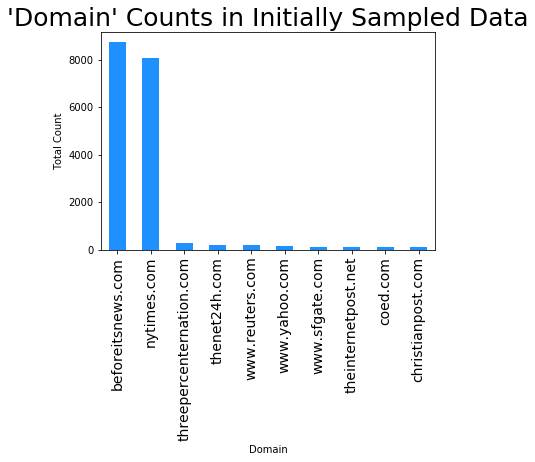

In [150]:
df.domain.value_counts().nlargest(10).plot(kind='bar', color='dodgerblue')
plt.xlabel('Domain')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=90)
plt.title("'Domain' Counts in Initially Sampled Data", fontsize=25)
plt.savefig('domaincounts.png', bbox_inches='tight', dpi = 300)

In [151]:
df.domain.value_counts().nlargest(10)

beforeitsnews.com           8733
nytimes.com                 8057
threepercenternation.com     267
thenet24h.com                210
www.reuters.com              187
www.yahoo.com                133
www.sfgate.com               121
theinternetpost.net          115
coed.com                     113
christianpost.com            107
Name: domain, dtype: int64

NYT and Beforeitsnews are vastly overrepresented in the data. Let's preform undersampling.

In [152]:
newdf =  df[df.groupby("domain")['domain'].transform('size') > 106]


In [153]:
grouped = newdf.groupby('domain', group_keys=False)

In [154]:
balanced_df = pd.DataFrame(grouped.apply(lambda x: x.sample(grouped.size().min()))).reset_index(drop=True)

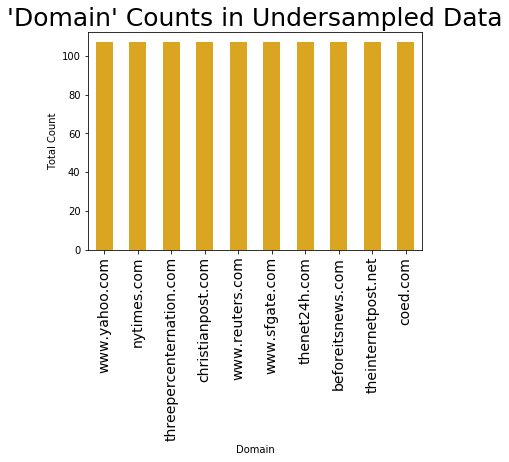

In [155]:
balanced_df.domain.value_counts().nlargest(10).plot(kind='bar', color='goldenrod')
plt.xlabel('Domain')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=90)
plt.title("'Domain' Counts in Undersampled Data", fontsize=25)
plt.savefig('domaincounts_under.png', bbox_inches='tight', dpi = 300)

In [156]:
balanced_df.domain.value_counts().sum()

1070

We could also just undersample the two most overrepresented classes for domain, although this approach is less common.

In [157]:
nyt = df[df['domain'] == "nytimes.com"]

In [158]:
nyt_sample = nyt.sample(100)

In [159]:
mask = df['domain'].isin(['nytimes.com', 'beforeitsnews.com'])
newdf = df[~mask]

In [160]:
bef = df[df['domain'] == "beforeitsnews.com"]

In [161]:
bef_sample = bef.sample(100)

In [162]:
df_undersampling = pd.concat([newdf, nyt_sample, bef_sample], axis=0)

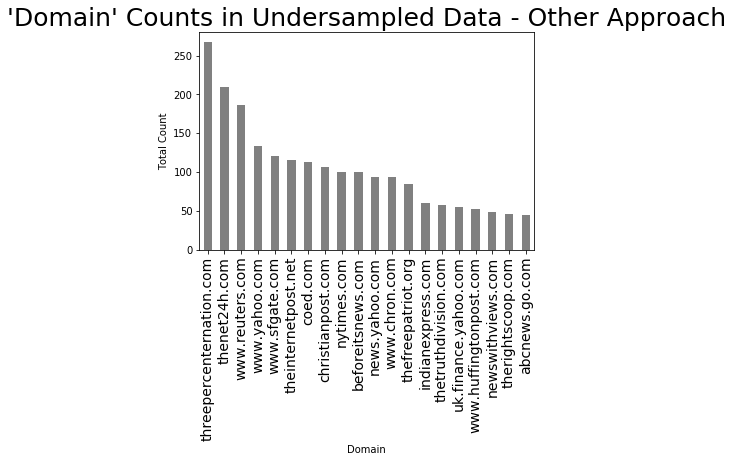

In [163]:
df_undersampling.domain.value_counts().nlargest(20).plot(kind='bar', color='grey')
plt.xlabel('Domain')
plt.ylabel('Total Count')
plt.xticks(fontsize=14, rotation=90)
plt.title("'Domain' Counts in Undersampled Data - Other Approach", fontsize=25)
plt.savefig('domaincounts_under2.png', bbox_inches='tight', dpi = 300)

Let's first base the analysis on the standard approach for undersampling. 

In [164]:
y = balanced_df['type']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['content'], y, test_size=0.33, random_state=53)



In [166]:
stopwords = stopwords.words('english')

In [167]:
for classifier in classifiers:
    countvect_pipeline = Pipeline([('preproc', pre_process()),
              ('cv', CountVectorizer(stop_words=stopwords)),
              ('clf',   classifier)])
    countvect_pipeline.fit(X_train,y_train)
    y_pred = countvect_pipeline.predict(X_test)
    print ("\n\nName of classifier being used with count vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(countvect_pipeline.score(X_test,y_test)))



Name of classifier being used with count vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.87      0.66      0.75       181
    reliable       0.72      0.90      0.80       173

    accuracy                           0.78       354
   macro avg       0.79      0.78      0.77       354
weighted avg       0.80      0.78      0.77       354


 Accuracy of classifier : 0.7768361581920904


Name of classifier being used with count vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.86      0.88      0.87       181
    reliable       0.87      0.85      0.86       173

    ac

In [168]:
for classifier in classifiers:
    tfidf_pipeline = Pipeline([
        #('preproc', pre_process()),
              ('tfidf', TfidfVectorizer(stop_words=stopwords)),
              ('clf',   classifier)])
    tfidf_pipeline.fit(X_train,y_train)
    y_pred = tfidf_pipeline.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pipeline.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.93      0.50      0.65       181
    reliable       0.65      0.96      0.77       173

    accuracy                           0.72       354
   macro avg       0.79      0.73      0.71       354
weighted avg       0.79      0.72      0.71       354


 Accuracy of classifier : 0.7231638418079096


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.87      0.92      0.89       181
    reliable       0.91      0.86      0.88       173

    ac

In [169]:
for classifier in classifiers:
    tfidf_pipeline_bigrams = Pipeline([
        #('preproc', pre_process()),
              ('tfidf', TfidfVectorizer(ngram_range=(2,2),stop_words=stopwords)),
              ('clf',   classifier)])
    tfidf_pipeline_bigrams.fit(X_train,y_train)
    y_pred = tfidf_pipeline_bigrams.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(tfidf_pipeline_bigrams.score(X_test,y_test)))



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.95      0.60      0.73       181
    reliable       0.70      0.97      0.81       173

    accuracy                           0.78       354
   macro avg       0.82      0.78      0.77       354
weighted avg       0.82      0.78      0.77       354


 Accuracy of classifier : 0.7768361581920904


Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        fake       0.90      0.78      0.83       181
    reliable       0.80      0.91      0.85       173

    ac

The most accurate model with tf-idf with linear SVC, with no additional preprocessing step.  Here is it without a pipeline to examine the most important features. 

In [170]:
tfidf_vect = TfidfVectorizer(stop_words=stopwords)

X_tfidf_train = tfidf_vect.fit_transform(X_train)

X_tfidf_test = tfidf_vect.transform(X_test)

In [171]:
linSVCclf = LinearSVC()

In [172]:
linSVCclf.fit(X_tfidf_train, y_train)
pred = linSVCclf.predict(X_tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print(score)

0.8898305084745762


In [173]:
show_most_informative_features(tfidf_vect, linSVCclf)

	-1.0133	advertisements 		2.4873	said           
	-0.9452	read           		1.5804	nov            
	-0.8297	com            		1.4714	2016           
	-0.7858	like           		1.4608	ap             
	-0.7322	google         		1.4421	says           
	-0.7317	video          		1.2739	reuters        
	-0.6796	check          		1.1719	christian      
	-0.6468	money          		1.1556	percent        
	-0.6226	coed           		1.0807	new            
	-0.6038	loading        		1.0772	million        
	-0.5977	military       		1.0482	mr             
	-0.5910	uncategorized  		0.9405	group          
	-0.5856	oil            		0.9123	york           
	-0.5744	think          		0.8709	november       
	-0.5448	baird          		0.8643	monday         
	-0.5434	hernandez      		0.8243	googletag      
	-0.5357	tebow          		0.8194	game           
	-0.5326	full           		0.7856	editing        
	-0.5282	ever           		0.7512	photo          
	-0.5252	wwe            		0.7507	reporting      
	-0.5175	print      

In [174]:
tfidf_vect_bigrams = TfidfVectorizer(ngram_range=(2,2),stop_words=stopwords)

In [175]:
X_tfidf__bigrams_train = tfidf_vect_bigrams.fit_transform(X_train)

In [176]:
X_tfidf__bigrams_test = tfidf_vect_bigrams.transform(X_test)

In [177]:
linSVCclf.fit(X_tfidf__bigrams_train, y_train)
pred = linSVCclf.predict(X_tfidf__bigrams_test)

In [178]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8418079096045198


In [179]:
show_most_informative_features(tfidf_vect_bigrams, nb_classifier)

	-14.0851	00 et          		-4.7049	get close      
	-14.0851	00 nov         		-4.9235	ian reconfiguration
	-14.0851	00 pbs         		-5.2659	developers reagent
	-14.0851	00 photo       		-5.5287	greg tlapek    
	-14.0851	00 pm          		-5.6735	13 conference  
	-14.0851	00 thru        		-5.7010	know today     
	-14.0851	000 200        		-5.7816	false flags    
	-14.0851	000 500        		-5.7861	increased odds 
	-14.0851	000 60         		-5.7908	heard weekend  
	-14.0851	000 829        		-5.8054	device inserted
	-14.0851	000 aboriginal 		-5.8747	killed two     
	-14.0851	000 acres      		-5.9483	evening alexander
	-14.0851	000 alcohol    		-5.9898	iran hold      
	-14.0851	000 cash       		-5.9923	give things    
	-14.0851	000 civil      		-6.0077	difference moral
	-14.0851	000 contributions		-6.0105	actively engaged
	-14.0851	000 customers  		-6.0243	found array    
	-14.0851	000 debt       		-6.0249	everybody page 
	-14.0851	000 dollars    		-6.0456	congress us    
	-14.0851	000 drin

Partially due to the amount of data, the informative features don't appear to be necessarily particularly informative.

Can unsupervised techniques, then, help us to glean insight from the dataset?

## Topic Modeling

Let's use the original sample, before the analysis considering domain, for topic modeling. 

In [3]:
df = pd.read_csv('data_large_new.csv',error_bad_lines=False, engine='python')

Skipping line 4341418: ',' expected after '"'
Skipping line 4341421: ',' expected after '"'
Skipping line 4341429: ',' expected after '"'
Skipping line 4341496: ',' expected after '"'
Skipping line 4341523: ',' expected after '"'
Skipping line 4341525: ',' expected after '"'
Skipping line 4341538: ',' expected after '"'
Skipping line 4341544: ',' expected after '"'
Skipping line 4341577: ',' expected after '"'
Skipping line 4341601: ',' expected after '"'
Skipping line 4341616: ',' expected after '"'
Skipping line 4341654: ',' expected after '"'
Skipping line 4341666: ',' expected after '"'
Skipping line 4341691: ',' expected after '"'
Skipping line 4341700: ',' expected after '"'
Skipping line 4341706: ',' expected after '"'
Skipping line 4341711: ',' expected after '"'
Skipping line 4341725: ',' expected after '"'
Skipping line 4341735: ',' expected after '"'
Skipping line 4341736: ',' expected after '"'
Skipping line 4341824: ',' expected after '"'
Skipping line 4341836: ',' expecte

In [4]:
df.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN
1,1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
2,2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
3,3,8,barenakedislam.com,hate,http://barenakedislam.com/2017/12/24/more-winn...,The White House has decided to quietly withdra...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"MORE WINNING! Israeli intelligence source, DEB...","Cleavis Nowell, Cleavisnowell, Clarence J. Fei...",NaN,[''],NaN,NaN,NaN,NaN
4,4,9,barenakedislam.com,hate,http://barenakedislam.com/2017/12/25/oh-trump-...,“The time has come to cut off the tongues of t...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"“Oh, Trump, you coward, you just wait, we will...","F.N. Lehner, Don Spilman, Clarence J. Feinour,...",NaN,[''],NaN,NaN,NaN,NaN


In [5]:
df.shape

(4342408, 17)

In [6]:
df = df[df['content'].notnull()]  


In [7]:
df.shape

(4341430, 17)

In [8]:
df = df[(df['type']=='fake') | (df['type'] == 'reliable')]

In [9]:
df.type.value_counts()

fake        504601
reliable     27483
Name: type, dtype: int64

In [10]:
reliable = df[(df['type']=='reliable')]

In [11]:
fake = df[(df['type']=='fake')]

In [12]:
reliable = reliable.sample(n=27000, random_state=1)


In [13]:
fake = fake.sample(n=27000, random_state=1)



In [14]:
df = pd.concat([reliable, fake])

In [15]:
punctuation = string.punctuation

In [16]:
english_stopwords = set(stopwords.words('english'))



In [17]:
ps = PorterStemmer()

In [18]:
def proc(row):
    text = row.lower()
    text = text.split()
    text =  [w for w in text if w.isalpha()]
    text = [w for w in text if w not in punctuation]
    text = [ps.stem(word) for word in text]
    text = [w for w in text if w not in english_stopwords]
    text = [w.encode('ascii', 'ignore').decode('ascii') for w in text]
    return text

In [19]:
df['content'] = df['content'].astype(str)

In [20]:
df['tokens_for_tm'] = df['content'].apply(proc)



In [21]:
dictionary = corpora.Dictionary(df['tokens_for_tm'])

In [22]:
doc_term_matrix = [dictionary.doc2bow(item) for item in df["tokens_for_tm"]]

In [23]:
lsi = models.LsiModel(doc_term_matrix, num_topics=3, id2word=dictionary)

In [30]:
def plotTopicProjections(model,dictionary,scale=False,plotNegative=True,nTerms=6):
    '''
    Convenience function to plot term importances in topics
    @plotNegative is for models that return -ve term importances
    @scale is either fixed at [-1,1] or autoscaled based on largest importance
    @model is LDA/LSI gensim model object
    '''
    
    topicProjections=model.get_topics()
    
    for n in range(topicProjections.shape[0]):
        #print(i)
        topicTerm=collections.Counter({dictionary[j]:p for j,p in\
                                       enumerate(topicProjections[n,:])})

        most = topicTerm.most_common(nTerms)[::-1]
        least = topicTerm.most_common()[-1*nTerms:]
        
        if not scale:
            plt.xlim(-1,1)
            maxExtent=1
        else:
            maxMost=max([m[1] for m in most])*1.1
            minLeast=min([l[1] for l in least])*1.1
            
            maxMost=topicProjections.max()*1.1
            minMost=topicProjections.min()*1.1
            
            maxExtent=max([abs(minLeast),abs(maxMost)])
            plt.xlim(-1*maxExtent,maxExtent)
                    
        plt.barh(range(nTerms),[m[1] for m in most])
        for i,m in enumerate(most):
            plt.annotate('{:s} ({:.3f})'.format(m[0],m[1]),\
                         xy=(0.1*maxExtent,i-0.1),xycoords='data',fontsize=20)
        
        if not plotNegative:
            if not scale:
                plt.xlim(0,1)
            else:
                plt.xlim(0,maxExtent)
        
        plt.barh(range(nTerms),[l[1] for l in least])
        for i,l in enumerate(least):
            plt.annotate('{:s} ({:.3f})'.format(l[0],l[1]),\
                         xy=(-0.1*maxExtent,i-0.1),xycoords='data',ha='right',fontsize=20)
        plt.axvline(color='grey')
        plt.title('Topic {:d}'.format(n))
        plt.yticks([],[])
        plt.xlabel('Projection')
        plt.show()
        
# From Next-Generation-Natural-Language-Processing-with-Python 
# https://github.com/PacktPublishing/Next-Generation-Natural-Language-Processing-with-Python/blob/master/Section%205/utils.py

In [31]:
output = lsi.print_topics(num_topics=3, num_words = 6)
print (output)

[(0, '0.458*"wa" + 0.295*"thi" + 0.260*"hi" + 0.209*"ha" + 0.150*"would" + 0.148*"one"'), (1, '-0.675*"de" + -0.445*"la" + -0.277*"que" + -0.237*"en" + -0.226*"lo" + -0.213*"el"'), (2, '0.365*"wa" + 0.204*"hi" + -0.195*"ga" + -0.187*"natur" + -0.186*"june" + -0.181*"market"')]


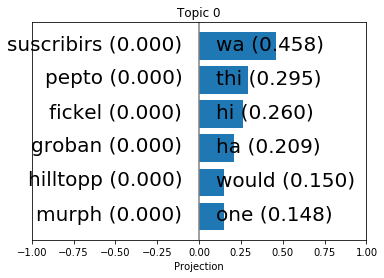

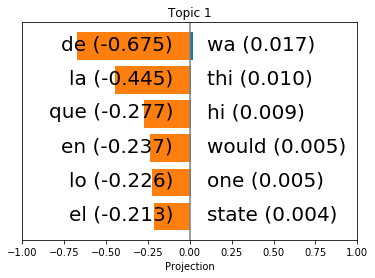

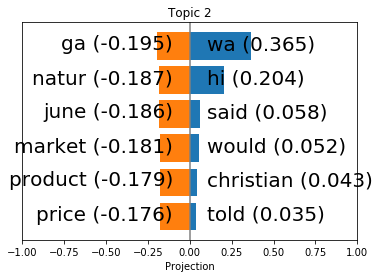

In [32]:
plotTopicProjections(lsi,dictionary)

These topics are not very useful. Let's include more stopwords from the above results (and results from some other runs of topic modeling) and try again. 

In [33]:
english_stopwords = stopwords.words('english')



In [34]:
english_stopwords.extend(['wa', 'thi', 'hi', 'one','ha','ga','new','en','lo','que','el','said','ani','know','mani','peopl','like','would','even','becaus','use','rec','ap','de','ru','go','also','may','us','think','make','get','two','f'])


In [35]:
english_stopwords.extend(nltk.corpus.stopwords.words('spanish'))

In [36]:
df['tokens_for_tm'] = df['content'].apply(proc)

In [37]:
dictionary = corpora.Dictionary(df['tokens_for_tm'])

In addition to adding stopwords, we can also limit extremely common and rare words in the dictionary.

In [38]:
dictionary.filter_extremes(no_below=50, no_above=0.5)

In [39]:
doc_term_matrix = [dictionary.doc2bow(item) for item in df["tokens_for_tm"]]

In [42]:
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)
output = lsi.print_topics(num_topics=7, num_words = 5)
print (output)

[(0, '0.175*"state" + 0.155*"american" + 0.145*"presid" + 0.131*"time" + 0.128*"report"'), (1, '-0.240*"market" + -0.215*"product" + -0.213*"natur" + -0.202*"price" + -0.188*"compani"'), (2, '0.298*"christian" + -0.223*"bush" + -0.202*"war" + -0.185*"report" + 0.179*"church"'), (3, '0.635*"market" + 0.270*"global" + 0.261*"report" + -0.146*"natur" + 0.142*"industri"'), (4, '-0.381*"state" + -0.198*"unit" + -0.197*"govern" + 0.184*"robert" + 0.178*"say"'), (5, '-0.228*"war" + 0.216*"cia" + -0.210*"christian" + -0.194*"say" + -0.177*"israel"'), (6, '-0.232*"obama" + 0.228*"cia" + 0.205*"intellig" + -0.193*"republican" + -0.142*"democrat"')]


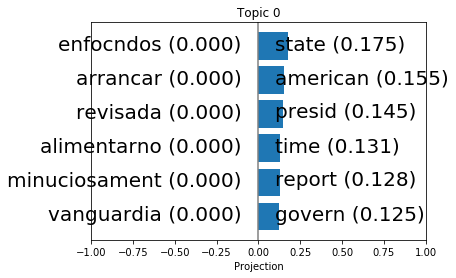

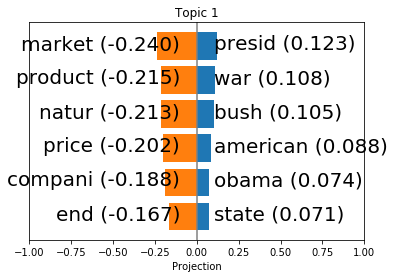

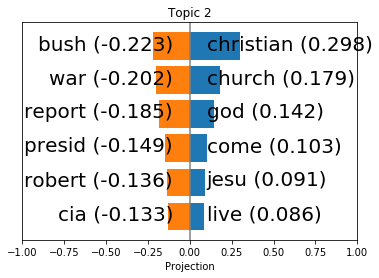

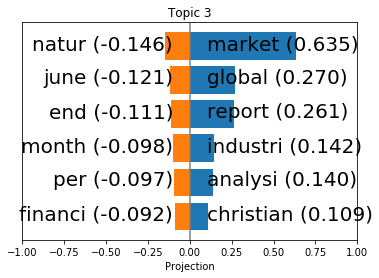

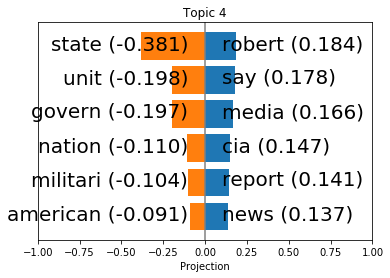

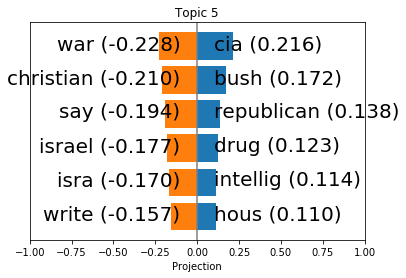

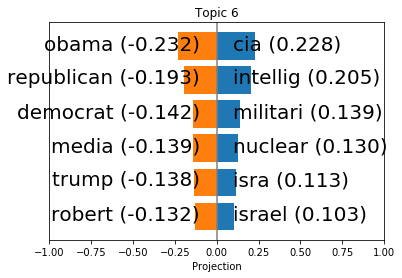

In [43]:
plotTopicProjections(lsi,dictionary)

Also use LDA, in addition to LSI: 

In [44]:
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [45]:
lda = models.LdaModel(doc_term_matrix, num_topics=7, id2word=dictionary)

In [46]:
output = lda.print_topics(num_topics=3, num_words = 5)
print (output)

[(6, '0.007*"polic" + 0.004*"kill" + 0.004*"gun" + 0.004*"report" + 0.004*"last"'), (1, '0.069*"xx" + 0.027*"" + 0.023*"est" + 0.021*"da" + 0.013*"m"'), (2, '0.007*"time" + 0.005*"want" + 0.005*"love" + 0.005*"come" + 0.005*"god"')]


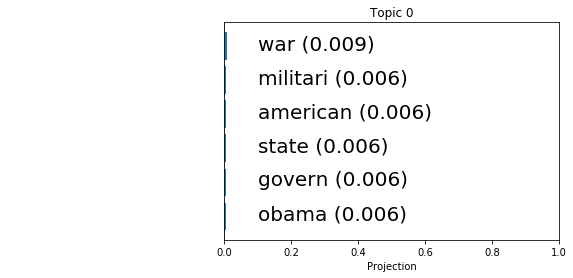

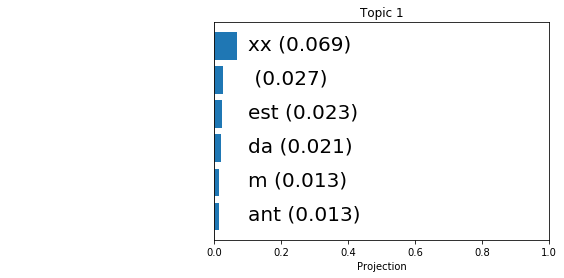

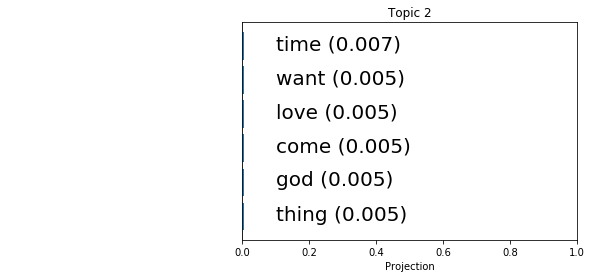

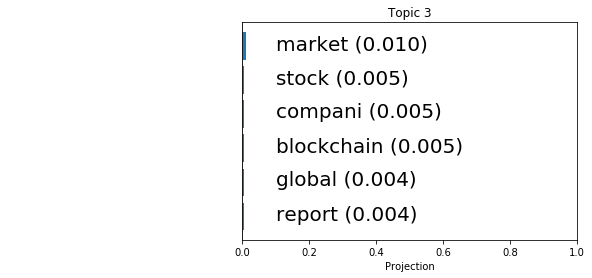

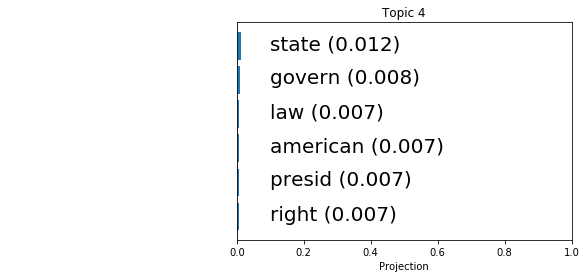

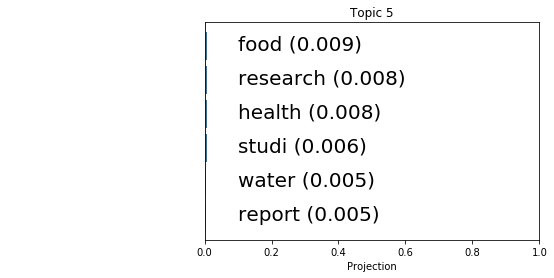

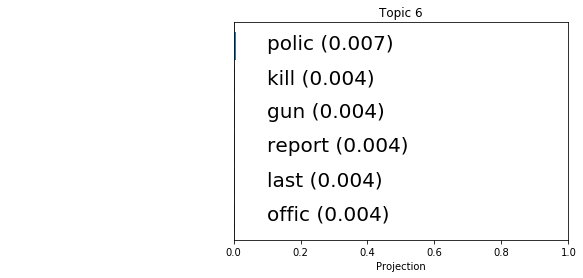

In [48]:
plotTopicProjections(lda,dictionary,plotNegative=False)

Several topics emerge from the sampled data, some more coherent than others. 

Let's perform topic modeling individually on articles labelled "fake" and articles labelled "reliable", to see if the topics are different for each set of labelled data:

In [49]:
fake.shape

(27000, 17)

In [50]:
fake['tokens_for_tm'] = fake['content'].apply(proc)

In [51]:
dictionary = corpora.Dictionary(fake["tokens_for_tm"])

In [52]:
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [53]:
doc_term_matrix = [dictionary.doc2bow(item) for item in fake["tokens_for_tm"]]

In [57]:
lsi = models.LsiModel(doc_term_matrix, num_topics=7, id2word=dictionary)
output = lsi.print_topics(num_topics=7, num_words = 5)
print (output)

[(0, '0.147*"market" + 0.131*"natur" + 0.131*"compani" + 0.127*"end" + 0.127*"product"'), (1, '-0.217*"natur" + -0.190*"june" + -0.175*"price" + -0.171*"product" + -0.165*"per"'), (2, '-0.683*"market" + -0.289*"global" + -0.244*"report" + -0.159*"industri" + -0.157*"analysi"'), (3, '0.340*"obama" + 0.274*"state" + -0.171*"gold" + 0.151*"govern" + 0.148*"unit"'), (4, '0.484*"gold" + 0.377*"bank" + 0.143*"govern" + 0.128*"money" + 0.127*"silver"'), (5, '0.664*"yanke" + 0.279*"york" + 0.220*"game" + 0.177*"brown" + 0.176*"hit"'), (6, '0.465*"brown" + -0.275*"yanke" + 0.184*"bank" + 0.167*"sentenc" + 0.167*"judg"')]


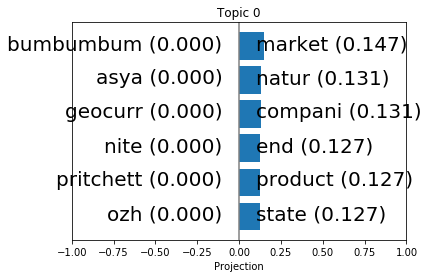

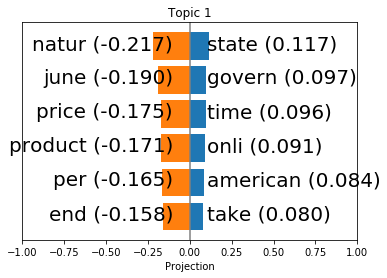

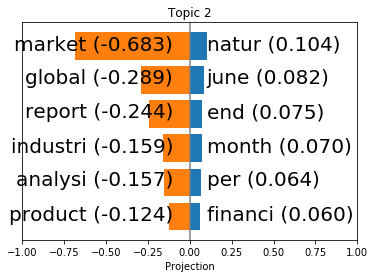

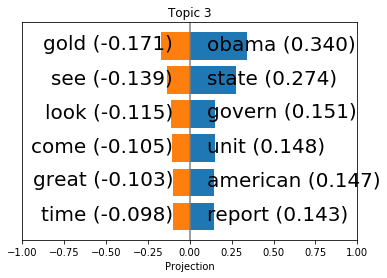

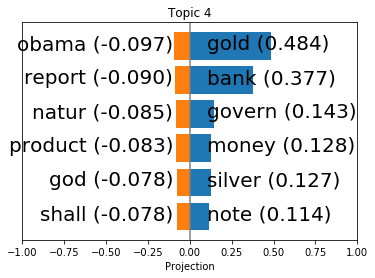

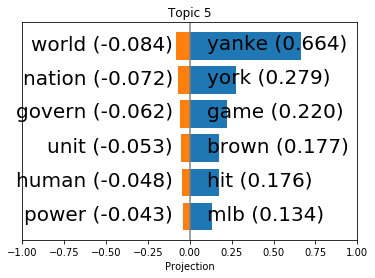

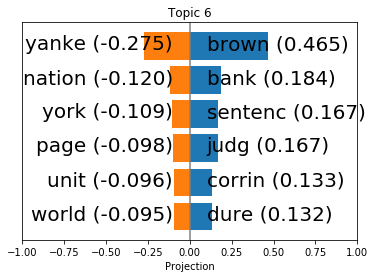

In [58]:
plotTopicProjections(lsi,dictionary)

Let's preform LDA:

In [59]:
lda = models.LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary)

output = lda.print_topics(num_topics=5, num_words = 5)
print (output)

[(0, '0.005*"time" + 0.005*"take" + 0.005*"want" + 0.005*"look" + 0.005*"see"'), (1, '0.005*"time" + 0.005*"world" + 0.005*"human" + 0.004*"god" + 0.004*"research"'), (2, '0.005*"blockchain" + 0.005*"food" + 0.004*"need" + 0.004*"help" + 0.004*"read"'), (3, '0.009*"state" + 0.007*"govern" + 0.006*"american" + 0.005*"presid" + 0.005*"nation"'), (4, '0.019*"market" + 0.008*"report" + 0.007*"price" + 0.007*"gold" + 0.007*"compani"')]


In [60]:
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.066912 -0.117268       1        1  27.773365
0      0.097128  0.010606       2        1  22.894506
4     -0.166309 -0.045550       3        1  19.571253
2     -0.019921  0.098227       4        1  16.496534
1      0.022190  0.053986       5        1  13.264348, topic_info=        Term          Freq         Total Category  logprob  loglift
162   market  19432.000000  19432.000000  Default  30.0000  30.0000
1905    gold   6874.000000   6874.000000  Default  29.0000  29.0000
2639   price   7444.000000   7444.000000  Default  28.0000  28.0000
350   global   8530.000000   8530.000000  Default  27.0000  27.0000
1172    bank   6543.000000   6543.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
671      see   1638.776733  10793.214844   Topic5  -5.9533   0.1351
232      doe   1471.636475   6556.390625   Topic5  -6.0609   0.5260
142      whi   1479.760742   7109.413574   Topic5  -6.0554   0.4506
339      way   1509.673706   9372.249023   Topic5  -6.0354   0.1942
903     part   1433.374146   7570.331543   Topic5  -6.0872   0.3559

[518 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8412      4  0.982041  abdomin
1         1  0.137105      add
1         2  0.287115      add
1         3  0.270620      add
1         4  0.271493      add
...     ...       ...      ...
5017      2  0.008405     zack
5017      3  0.976604     zack
5017      4  0.011766     zack
5017      5  0.001681     zack
1663      5  0.988906     zion

[1682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

Setting lambda to 0.2 in pyLDAvis yielded the most interesting results. Topic 1 is related to religion. Topic 2 concern business, the ecnomy, and investing. Topic 3 seems to be mostly associated with firearms snd politics. Topic 4 is associated with food, heath, and science. Topic 5 is the least coherent topic -- it seems to associated with both sports and politics. 

<img src="viz-for-proj/fake/1.png">

<img src="viz-for-proj/fake/2.png">

<img src="viz-for-proj/fake/3.png">

<img src="viz-for-proj/fake/4.png">

<img src="viz-for-proj/fake/5.png">

For articles labelled "reliable":

In [61]:
reliable = df[df['type']=='reliable']

In [62]:
reliable.shape

(27000, 18)

In [63]:
reliable['tokens_for_tm'] = reliable['content'].apply(proc)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
dictionary = corpora.Dictionary(reliable['tokens_for_tm'])
dictionary.filter_extremes(no_below=20, no_above=0.5)
doc_term_matrix = [dictionary.doc2bow(item) for item in reliable["tokens_for_tm"]]
lsi = models.LsiModel(doc_term_matrix, num_topics=5, id2word=dictionary)
output = lsi.print_topics(num_topics=5, num_words = 5)
print (output)

[(0, '0.183*"presid" + 0.176*"american" + 0.176*"state" + 0.155*"war" + 0.135*"report"'), (1, '0.409*"christian" + -0.243*"bush" + 0.230*"church" + -0.214*"war" + -0.154*"robert"'), (2, '-0.358*"christian" + -0.267*"say" + -0.225*"robert" + -0.197*"write" + 0.189*"state"'), (3, '0.257*"bush" + -0.233*"israel" + -0.229*"isra" + -0.187*"nuclear" + -0.182*"state"'), (4, '-0.289*"christian" + 0.218*"diet" + -0.217*"bush" + 0.211*"eat" + 0.175*"cancer"')]


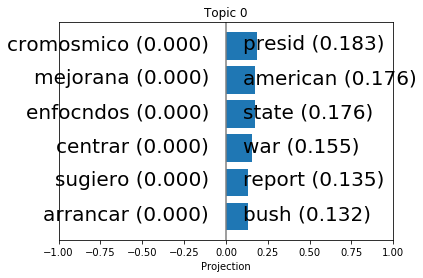

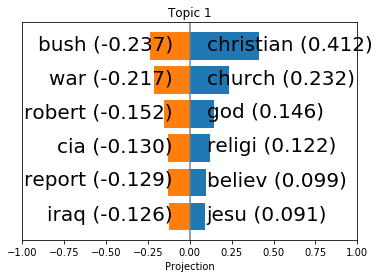

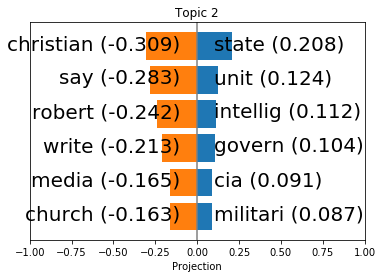

In [65]:
plotTopicProjections(lsi,dictionary)

Using LDA:

In [93]:
lda = models.LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary)

In [94]:
output = lda.print_topics(num_topics=5, num_words = 5)
print (output)

[(0, '0.008*"studi" + 0.007*"eat" + 0.007*"food" + 0.006*"cancer" + 0.006*"help"'), (1, '0.014*"god" + 0.011*"church" + 0.011*"christian" + 0.009*"jesu" + 0.007*"love"'), (2, '0.006*"state" + 0.006*"christian" + 0.006*"religi" + 0.005*"presid" + 0.005*"right"'), (3, '0.011*"christian" + 0.005*"told" + 0.005*"state" + 0.005*"islam" + 0.005*"church"'), (4, '0.006*"war" + 0.006*"presid" + 0.006*"american" + 0.006*"state" + 0.005*"bush"')]


In [95]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.008012  0.121958       1        1  32.651367
2     -0.044942  0.050002       2        1  27.172276
3     -0.059254  0.043907       3        1  20.946495
1     -0.101701 -0.164767       4        1  10.853868
0      0.213909 -0.051101       5        1   8.375996, topic_info=           Term          Freq         Total Category  logprob  loglift
1019  christian  37404.000000  37404.000000  Default  30.0000  30.0000
24          god  13356.000000  13356.000000  Default  29.0000  29.0000
1377     church  22254.000000  22254.000000  Default  28.0000  28.0000
1191       jesu   7933.000000   7933.000000  Default  27.0000  27.0000
1688      studi   7449.000000   7449.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
142       could   2380.025146  18100.316406   Topic5  -5.5369   0.4510
1838        whi   1934.757324   9329.449219   Topic5  -5.7441   0.9066
45         much   2000.560913  13133.802734   Topic5  -5.7106   0.5980
204        year   1978.527344  18604.019531   Topic5  -5.7217   0.2388
989        time   1943.447388  22483.626953   Topic5  -5.7396   0.0315

[477 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
205       1  0.013398   abduct
205       2  0.001914   abduct
205       3  0.981865   abduct
205       4  0.001914   abduct
2483      1  0.001129    abort
...     ...       ...      ...
5453      1  0.994804  zionist
5453      2  0.001429  zionist
5453      3  0.001429  zionist
5453      4  0.001429  zionist
5453      5  0.001429  zionist

[1501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

As with the documents labelled "fake" lambda was set to 0.2 in pyLDAvis. Topic 1 seemed most associated with international politics and foreign affairs, with the most relevant terms being linked to war in the Middle East. Topic 2 included terms linked with abortion, religious, and LGBT concerns, and is clearly associated with controversial social issues in the United States. Topic 3 is less coherent and is partially associated with conflict in the Middle East. Topic 4 is the result of Spanish-language documents (which seem to be of a religious nature) in the data, which were labelled as reliable. Topic 5 is associated with food and health.

<img src="viz-for-proj/real/1.png">

<img src="viz-for-proj/real/2.png">

<img src="viz-for-proj/real/3.png">

<img src="viz-for-proj/real/4.png">

<img src="viz-for-proj/real/5.png">

One interesting difference between the LDA topics in the "reliable" and "fake" data is the terms referring to people. "Obama" is the top term in Topic 3, the "political" topic in the "fake" dataset, while "Bush" is the top term in Topic 1 of the "reliable" documents. Additionally Topic 1 in the "reliable" data seemed to be more associated with foreign affairs, while Topic 3 in the "fake" data seemed more concerned with domestic issues, such as the 2nd ammendment. Additionally, there were noteworthy differents between the food/heath topics in the "fake" and "reliable" data. The "reliable" topic (5) included terms mainly associated with food and the nutrients and micronutriets in it, as well disease and verbs related to eating.  The "fake" food/health topic, on the other hand, included terms such as "vaccin", "radiat", and "plastic", as well as general science words and terms associated with outer space, such as "moon", "planet", "space","solar", and "orbit". Thus, the food/health topic in the "fake" data was more of a "science as a whole" topic, where as in the "reliable" data it was more distinctly a food/health topic. 

## multi-class classification

In [124]:
df = pd.read_csv('newly_sampled_data.csv')

Text(0.5, 1.0, "'Type' Counts in Initally Sampled Data")

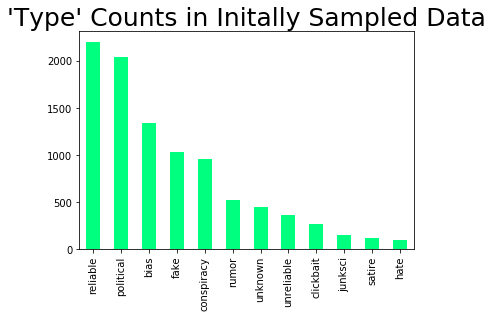

In [125]:
df.type.value_counts().plot(kind='bar',color='springgreen')
plt.title("'Type' Counts in Initally Sampled Data", fontsize=25)

Take the top four categories to make a new df. 

In [126]:
fake_new_df = df[df['type']== 'fake'].sample(n=1000, random_state=0)

bias_new_df = df[df['type']== 'bias'].sample(n=1000, random_state=0)

political_new_df = df[df['type']== 'political'].sample(n=1000, random_state=0)

reliable_new_df = df[df['type']== 'reliable'].sample(n=1000, random_state=0)

new_df = pd.concat([fake_new_df, reliable_new_df,bias_new_df,political_new_df])

Text(0.5, 1.0, "New 'Type' Counts in Sampled Data")

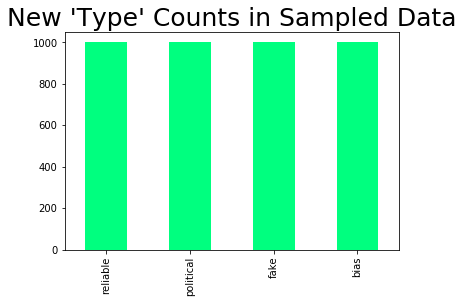

In [128]:
new_df.type.value_counts().plot(kind='bar',color='springgreen')
plt.title("New 'Type' Counts in Sampled Data", fontsize=25)

In [129]:
new_df.head()

y = new_df.type

X_train, X_test, y_train, y_test = train_test_split(new_df['content'], y, test_size=0.33, random_state=53)



Name of classifier being used with count vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.90      0.50      0.65       348
        fake       0.61      0.68      0.64       290
   political       0.54      0.75      0.63       335
    reliable       0.80      0.77      0.78       347

    accuracy                           0.68      1320
   macro avg       0.71      0.68      0.68      1320
weighted avg       0.72      0.68      0.68      1320


 Accuracy of classifier : 0.6757575757575758
                pred:fake  pred:political  pred:reliable  pred:bias
true:fake             198              64             22          6
true:political         43             252             30         10
true:reliable          35              42            267          3
true:bias              51             107             15        175
cv_Multino.png


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Name of classifier being used with count vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.66      0.63      0.65       348
        fake       0.61      0.72      0.66       290
   political       0.60      0.56      0.58       335
    reliable       0.79      0.77      0.78       347

    accuracy                           0.67      1320
   macro avg       0.67      0.67      0.67      1320
weighted avg       0.67      0.67      0.67      1320


 Accuracy of classifier : 0.6666666666666666
                pred:fake  pred:political  pred:reliable  pred:bias
true:fake             208              32             19         31
true:political         60             186             29         60
t

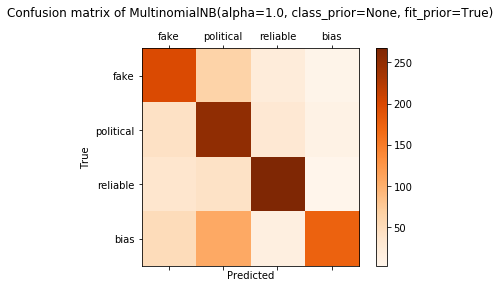

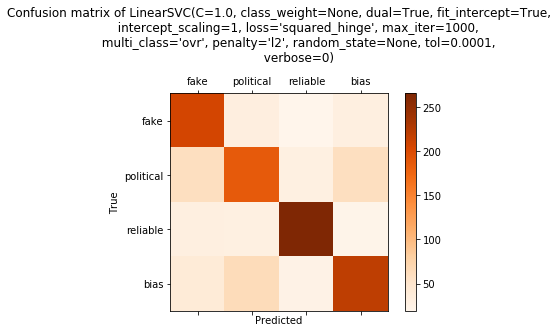

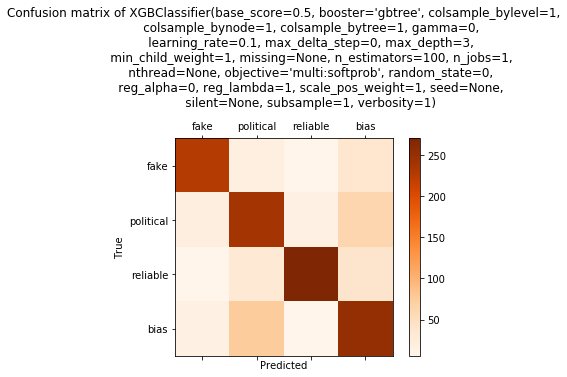

In [130]:
for classifier in classifiers:
    pipeline_w_cv = Pipeline([
              ('cv', CountVectorizer(stop_words='english')),
              ('clf',   classifier)])
    pipeline_w_cv.fit(X_train,y_train)
    y_pred = pipeline_w_cv.predict(X_test)
    print ("\n\nName of classifier being used with count vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_cv.score(X_test,y_test)))
    labels = ['fake','political','reliable','bias']
    cmtx = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
        index=['true:fake', 'true:political','true:reliable','true:bias' ], 
        columns=['pred:fake', 'pred:political', 'pred:reliable', 'pred:bias'])
    print(cmtx)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cmtx,cmap='Oranges')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fig.colorbar(cax)
    plt.title('Confusion matrix of '+ str(classifier) + "\n")
    saveas = "cv_" + str(classifier)[0:7] +'.png'
    print (saveas)
    plt.savefig(saveas, bbox_inches='tight', dpi = 300)



Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.91      0.48      0.63       348
        fake       0.66      0.63      0.64       290
   political       0.51      0.80      0.62       335
    reliable       0.80      0.78      0.79       347

    accuracy                           0.67      1320
   macro avg       0.72      0.67      0.67      1320
weighted avg       0.73      0.67      0.67      1320


 Accuracy of classifier : 0.671969696969697
                pred:fake  pred:political  pred:reliable  pred:bias
true:fake             182              78             23          7
true:political         36             268             25          6
true:reliable          19              56            269          3
true:bias              38             124             18        168
tfidf_Multi.png


Name of classifier 

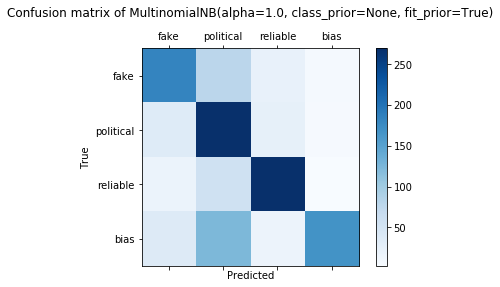

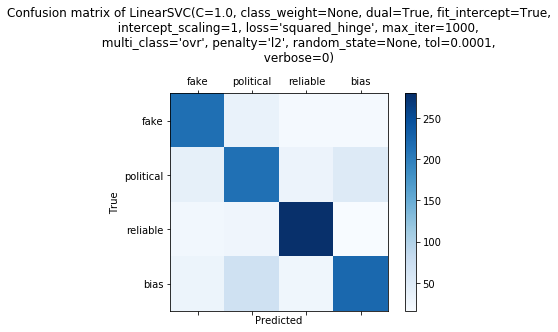

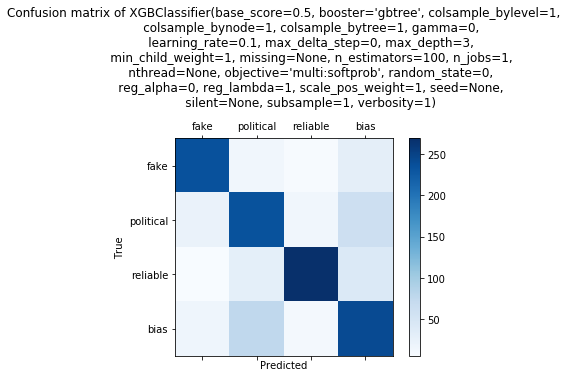

In [131]:
for classifier in classifiers:
    pipeline_w_tfidf = Pipeline([
              ('tfidf', TfidfVectorizer(stop_words='english')),
              ('clf',   classifier)])
    pipeline_w_tfidf.fit(X_train,y_train)
    y_pred = pipeline_w_tfidf.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_tfidf.score(X_test,y_test)))
    labels = ['fake','political','reliable','bias']
    cmtx = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
        index=['true:fake', 'true:political','true:reliable','true:bias' ], 
        columns=['pred:fake', 'pred:political', 'pred:reliable', 'pred:bias'])
    print(cmtx)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cmtx,cmap='Blues')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fig.colorbar(cax)
    plt.title('Confusion matrix of '+ str(classifier) + "\n")
    saveas = "tfidf_" + str(classifier)[0:5] +'.png'
    print (saveas)
    plt.savefig(saveas, bbox_inches='tight', dpi = 300)

### What happens when all of the original labels from the dataset are included in the classifier (not only 'fake','political','reliable','bias', but all of them)?

In [132]:
df = pd.read_csv('newly_sampled_data.csv')

In [133]:
df.shape

(10000, 16)

In [134]:
df = df[pd.notnull(df['content'])]

In [135]:
df = df[pd.notnull(df['type'])]

In [136]:
df.shape

(9528, 16)

Text(0.5, 1.0, "'Type' Counts in Initally Sampled Data")

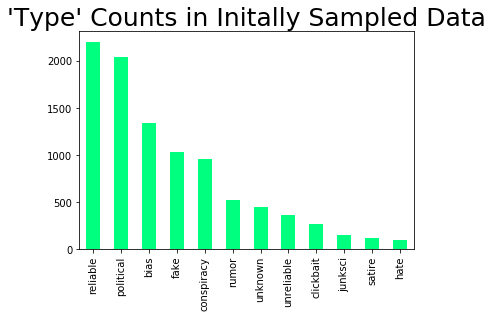

In [138]:
df.type.value_counts().plot(kind='bar',color='springgreen')
plt.title("'Type' Counts in Initally Sampled Data", fontsize=25)

In [139]:
df.type.value_counts()

reliable      2201
political     2040
bias          1342
fake          1031
conspiracy     954
rumor          523
unknown        449
unreliable     364
clickbait      268
junksci        145
satire         118
hate            93
Name: type, dtype: int64

In [140]:
y = df.type

X_train, X_test, y_train, y_test = train_test_split(df['content'], y, test_size=0.20, random_state=53)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Name of classifier being used with count vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.72      0.55      0.63       258
   clickbait       1.00      0.02      0.04        52
  conspiracy       0.67      0.45      0.53       184
        fake       0.59      0.54      0.56       209
        hate       0.00      0.00      0.00        18
     junksci       0.89      0.23      0.36        35
   political       0.47      0.82      0.59       384
    reliable       0.67      0.84      0.74       463
       rumor       0.93      0.39      0.55       103
      satire       1.00      0.05      0.10        19
     unknown       0.88      0.23      0.36        92
  unreliable       1.00      0.67      0.81        89

    accuracy                           0.61      1906
   macro avg       0.73      0.40      0.44      1906
weighted avg       0.67      0.61      0.59  

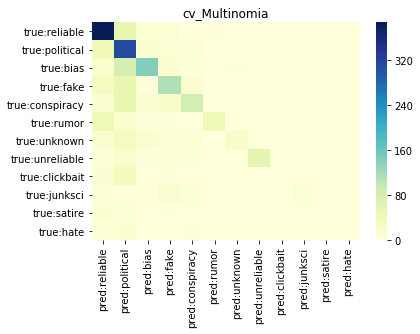

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Name of classifier being used with count vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.58      0.57      0.58       258
   clickbait       0.29      0.27      0.28        52
  conspiracy       0.52      0.58      0.55       184
        fake       0.57      0.56      0.57       209
        hate       0.18      0.11      0.14        18
     junksci       0.67      0.46      0.54        35
   political       0.59      0.63      0.61       384
    reliable       0.80      0.80      0.80       463
       rumor       0.73      0.67      0.70       103
      satire       0.33      0.26      0.29        19
     unknown       0.36      0.39      0.37        92
  unreliable       0.88      0.69    

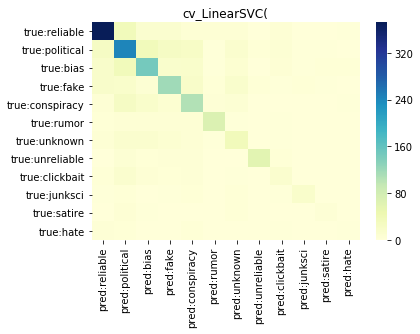



Name of classifier being used with count vectorizer: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.79      0.55      0.65       258
   clickbait       1.00      0.27      0.42        52
  conspiracy       0.93      0.48      0.63       184
        fake       0.79      0.77      0.78       209
        hate       0.75      0.33      0.46        18
     junksci       0.86      0.51      0.64        35
   political       0.44      0.86      0.58       384
    reliable  

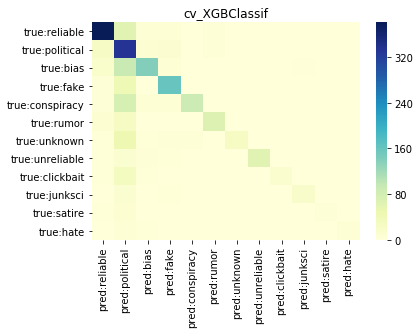

<Figure size 432x288 with 0 Axes>

In [141]:
for classifier in classifiers:
    pipeline_w_cv = Pipeline([
              ('cv', CountVectorizer(stop_words='english')),
              ('clf',   classifier)])
    pipeline_w_cv.fit(X_train,y_train)
    y_pred = pipeline_w_cv.predict(X_test)
    print ("\n\nName of classifier being used with count vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_cv.score(X_test,y_test)))
    labels = ['reliable', 'political','bias','fake','conspiracy','rumor','unknown','unreliable', 'clickbait','junksci','satire','hate']
    cmtx = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
    index=['true:reliable', 'true:political','true:bias','true:fake','true:conspiracy','true:rumor','true:unknown','true:unreliable', 'true:clickbait','true:junksci','true:satire','true:hate'], 
    columns=['pred:reliable', 'pred:political', 'pred:bias', 'pred:fake','pred:conspiracy','pred:rumor','pred:unknown','pred:unreliable','pred:clickbait','pred:junksci','pred:satire','pred:hate']
)
    print(cmtx)
    

    
    title = "cv_" + str(classifier)[0:10]
    
    
    
    ax = sns.heatmap(cmtx, cmap="YlGnBu")
    
    
    ax.set_title(title)

    saveas = "all_labels_cv_" + str(classifier)[0:5] +'.png'
    plt.show()
    ax.figure.savefig(saveas, bbox_inches='tight', dpi = 300)
    plt.clf()


 

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Name of classifier being used with tfidf vectorizer: 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.99      0.35      0.52       258
   clickbait       0.00      0.00      0.00        52
  conspiracy       1.00      0.24      0.39       184
        fake       1.00      0.08      0.15       209
        hate       0.00      0.00      0.00        18
     junksci       0.00      0.00      0.00        35
   political       0.36      0.84      0.50       384
    reliable       0.51      0.88      0.65       463
       rumor       1.00      0.03      0.06       103
      satire       0.00      0.00      0.00        19
     unknown       1.00      0.05      0.10        92
  unreliable       1.00      0.53      0.69        89

    accuracy                           0.49      1906
   macro avg       0.57      0.25      0.25      1906
weighted avg       0.69      0.49      0.42  

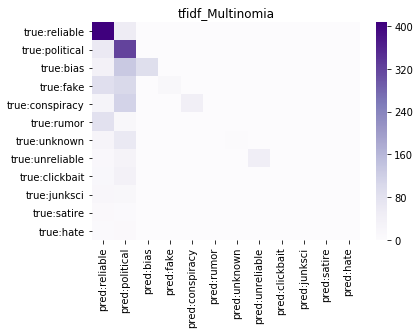



Name of classifier being used with tfidf vectorizer: 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.63      0.61      0.62       258
   clickbait       0.73      0.21      0.33        52
  conspiracy       0.67      0.58      0.62       184
        fake       0.70      0.72      0.71       209
        hate       0.40      0.11      0.17        18
     junksci       0.78      0.51      0.62        35
   political       0.57      0.77      0.65       384
    reliable       0.80      0.87      0.83       463
       rumor       0.77      0.77      0.77       103
      satire       0.83      0.26      0.40        19
     unknown       0.64      0.29      0.40        92
  unreliable       1.00      0.70    

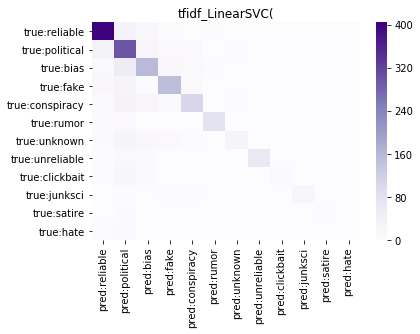



Name of classifier being used with tfidf vectorizer: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Classification Report : 

              precision    recall  f1-score   support

        bias       0.71      0.59      0.64       258
   clickbait       0.88      0.27      0.41        52
  conspiracy       0.79      0.50      0.61       184
        fake       0.87      0.80      0.83       209
        hate       0.83      0.28      0.42        18
     junksci       0.76      0.46      0.57        35
   political       0.49      0.85      0.62       384
    reliable  

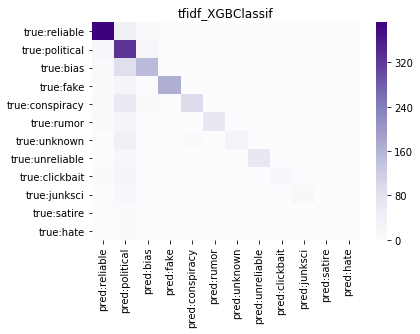

<Figure size 432x288 with 0 Axes>

In [142]:
for classifier in classifiers:
    pipeline_w_tfidf = Pipeline([
              ('tfidf', TfidfVectorizer()),
              ('clf',   classifier)])
    pipeline_w_tfidf.fit(X_train,y_train)
    y_pred = pipeline_w_tfidf.predict(X_test)
    print ("\n\nName of classifier being used with tfidf vectorizer: \n\n" + str(classifier) + 
           "\n\nClassification Report : \n\n"+ str(metrics.classification_report(y_test,y_pred))  + "\n\n Accuracy of classifier : " + str(pipeline_w_tfidf.score(X_test,y_test)))
    cmtx = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred,  labels=labels), 
    index=['true:reliable', 'true:political','true:bias','true:fake','true:conspiracy','true:rumor','true:unknown','true:unreliable', 'true:clickbait','true:junksci','true:satire','true:hate'], 
    columns=['pred:reliable', 'pred:political', 'pred:bias', 'pred:fake','pred:conspiracy','pred:rumor','pred:unknown','pred:unreliable','pred:clickbait','pred:junksci','pred:satire','pred:hate']
)
    print(cmtx)
    
    
    
    title = "tfidf_" + str(classifier)[0:10]
    
    
    
    ax = sns.heatmap(cmtx, cmap="Purples")
    ax.set_title(title)
    
    
    
    plt.show()
    saveas = "all_labels_tfidf_" + str(classifier)[0:5] +'.png'
    ax.figure.savefig(saveas, bbox_inches='tight', dpi = 300)
    plt.clf()
 